In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense, Input
from scipy.stats import pearsonr
from matplotlib import pyplot as plt



Prepare the data into scaled values

In [13]:
wine_df = pd.read_csv('../wine+quality/winequality-red.csv', sep=';')

X_orig = wine_df.drop('quality', axis=1)
X = StandardScaler().fit_transform(X_orig)
y = wine_df['quality']


Train the SVR model with a 3:1 train-test split

In [14]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=1)
X_test, X_validate, y_test, y_validate = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1)


In [15]:

def train_svr(X_train, y_train):
    model = SVR(kernel='rbf', C=0.95, epsilon=0.13)
    model.fit(X_train, y_train)
    return model

svr = train_svr(X_train, y_train)


Train the ANN model with a 3:1:1 train-validation-test split

In [16]:



def train_ann(X_train, y_train, X_validate, y_validate):
    ann_model = Sequential()
    ann_model.add(Input(shape=(X_train.shape[1],)))
    ann_model.add(Dense(15, activation='relu'))
    ann_model.add(Dense(15, activation='relu'))
    ann_model.add(Dense(15, activation='relu'))
    ann_model.add(Dense(1, activation='linear'))
    ann_model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    ann_model.fit(X_train, y_train, epochs=5, batch_size=16, validation_data=(X_validate, y_validate))
    return ann_model

ann = train_ann(X_train, y_train, X_validate, y_validate)


Epoch 1/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 37.4309 - mae: 6.0370 - val_loss: 29.6701 - val_mae: 5.3841
Epoch 2/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 26.8519 - mae: 5.1098 - val_loss: 15.2218 - val_mae: 3.7615
Epoch 3/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.9981 - mae: 3.0340 - val_loss: 3.1951 - val_mae: 1.5199
Epoch 4/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9491 - mae: 1.4131 - val_loss: 2.0156 - val_mae: 1.1584
Epoch 5/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0367 - mae: 1.1192 - val_loss: 1.6661 - val_mae: 1.0470


Define the function for calculating the performance metrics

In [17]:
# Function to calculate R (Pearson correlation coefficient), MSE, and MAPE
def calculate_metrics(y_true, y_pred):
    # Calculate R (Pearson correlation coefficient)
    r, _ = pearsonr(y_true, y_pred)

    # Calculate MSE
    mse = mean_squared_error(y_true, y_pred)

    # Calculate MAPE
    mape = mean_absolute_percentage_error(y_true, y_pred)

    return r, mse, mape


Create a prediction using both models and an ensemble of both models

In [18]:
svr_pred = svr.predict(X_test)
ann_pred = ann.predict(X_test).flatten()

r_svr, mse_svr, mape_svr = calculate_metrics(y_test, svr_pred)
r_ann, mse_ann, mape_ann = calculate_metrics(y_test, ann_pred)

ensemble_pred = (svr_pred + ann_pred) / 2

r_ensemble, mse_ensemble, mape_ensemble = calculate_metrics(y_test, ensemble_pred)

print(f"SVR - R: {r_svr:.4f}, MSE: {mse_svr:.4f}, MAPE: {mape_svr:.4f}")
print(f"ANN - R: {r_ann:.4f}, MSE: {mse_ann:.4f}, MAPE: {mape_ann:.4f}")
print(f"Ensemble - R: {r_ensemble:.4f}, MSE: {mse_ensemble:.4f}, MAPE: {mape_ensemble:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
SVR - R: 0.5635, MSE: 0.4056, MAPE: 0.0892
ANN - R: 0.1238, MSE: 1.7722, MAPE: 0.1847
Ensemble - R: 0.3217, MSE: 0.7426, MAPE: 0.1200


In [19]:
# Initialize lists to store metrics
train_r_values = []
train_mse_values = []
train_mape_values = []
test_r_values = []
test_mse_values = []
test_mape_values = []

svr_train_r_values = []
svr_train_mse_values = []
svr_train_mape_values = []
svr_test_r_values = []
svr_test_mse_values = []
svr_test_mape_values = []

ann_train_r_values = []
ann_train_mse_values = []
ann_train_mape_values = []
ann_test_r_values = []
ann_test_mse_values = []
ann_test_mape_values = []

# Repeat the experiment for random_state 1 to 100
for random_state in range(1, 3):
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=1)
    X_test, X_validate, y_test, y_validate = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1)

    # Initialize and train the SVR model with RBF kernel
    svr = train_svr(X_train, y_train)
    ann = train_ann(X_train, y_train, X_validate, y_validate)
    # Make predictions for training and testing sets
    y_train_svr_pred = svr.predict(X_train)
    y_test_svr_pred = svr.predict(X_test)
    Y_train_ann_pred = ann.predict(X_train).flatten()
    y_test_ann_pred = ann.predict(X_test).flatten()

    y_train_ensemble_pred = (y_train_svr_pred + Y_train_ann_pred) / 2
    y_test_ensemble_pred = (y_test_svr_pred + y_test_ann_pred) / 2

    #svr mertics
    train_r_svr, train_mse_svr, train_mape_svr = calculate_metrics(y_train, y_train_svr_pred)
    test_r_svr, test_mse_svr, test_mape_svr = calculate_metrics(y_test, y_test_svr_pred)

    svr_train_r_values.append(train_r_svr)
    svr_train_mse_values.append(train_mse_svr)
    svr_train_mape_values.append(train_mape_svr)
    svr_test_r_values.append(test_r_svr)
    svr_test_mse_values.append(test_mse_svr)
    svr_test_mape_values.append(test_mape_svr)

    #ann metrics
    train_r_ann, train_mse_ann, train_mape_ann = calculate_metrics(y_train, Y_train_ann_pred)
    test_r_ann, test_mse_ann, test_mape_ann = calculate_metrics(y_test, y_test_ann_pred)

    ann_train_r_values.append(train_r_ann)
    ann_train_mse_values.append(train_mse_ann)
    ann_train_mape_values.append(train_mape_ann)
    ann_test_r_values.append(test_r_ann)
    ann_test_mse_values.append(test_mse_ann)
    ann_test_mape_values.append(test_mape_ann)

    # Calculate metrics for training data set
    train_r, train_mse, train_mape = calculate_metrics(y_train, y_train_ensemble_pred)

    # Calculate metrics for testing data set
    test_r, test_mse, test_mape = calculate_metrics(y_test, y_test_ensemble_pred)

    # Store the metrics in the lists
    train_r_values.append(train_r)
    train_mse_values.append(train_mse)
    train_mape_values.append(train_mape)
    test_r_values.append(test_r)
    test_mse_values.append(test_mse)
    test_mape_values.append(test_mape)

    print(random_state)


Epoch 1/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 29.1789 - mae: 5.3258 - val_loss: 17.3229 - val_mae: 4.0443
Epoch 2/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13.8108 - mae: 3.4945 - val_loss: 4.3222 - val_mae: 1.6926
Epoch 3/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1598 - mae: 1.6168 - val_loss: 3.1512 - val_mae: 1.4112
Epoch 4/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2290 - mae: 1.3998 - val_loss: 2.5545 - val_mae: 1.2458
Epoch 5/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5879 - mae: 1.2541 - val_loss: 2.1372 - val_mae: 1.1431
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1
Epoch 1/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 29.3234 - mae: 5.3461 - val_loss: 19.3129 - val_mae: 4.2819
Epoch 2/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14.2344 - mae: 3.5612 - val_loss: 4.8932 - val_mae: 1.8029
Epoch 3/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7399 - mae: 1.5874 - val_loss: 2.5366 - val_mae: 

In [20]:
# Reference values for SVM model
reference_values = {
    "Training Data Set": {"R": 0.7797, "MSE": 0.267, "MAPE": 0.1426},
    "Testing Data Set": {"R": 0.5971, "MSE": 0.3862, "MAPE": 0.1355},
    "Training Data Set SVR": {"R": np.mean(svr_train_r_values), "MSE": np.mean(svr_train_mse_values), "MAPE": np.mean(svr_train_mape_values)},
    "Testing Data Set SVR": {"R": np.mean(svr_test_r_values), "MSE": np.mean(svr_test_mse_values), "MAPE": np.mean(svr_test_mape_values)},
    "Training Data Set ANN": {"R": np.mean(ann_train_r_values), "MSE": np.mean(ann_train_mse_values), "MAPE": np.mean(ann_train_mape_values)},
    "Testing Data Set ANN": {"R": np.mean(ann_test_r_values), "MSE": np.mean(ann_test_mse_values), "MAPE": np.mean(ann_test_mape_values)}
}


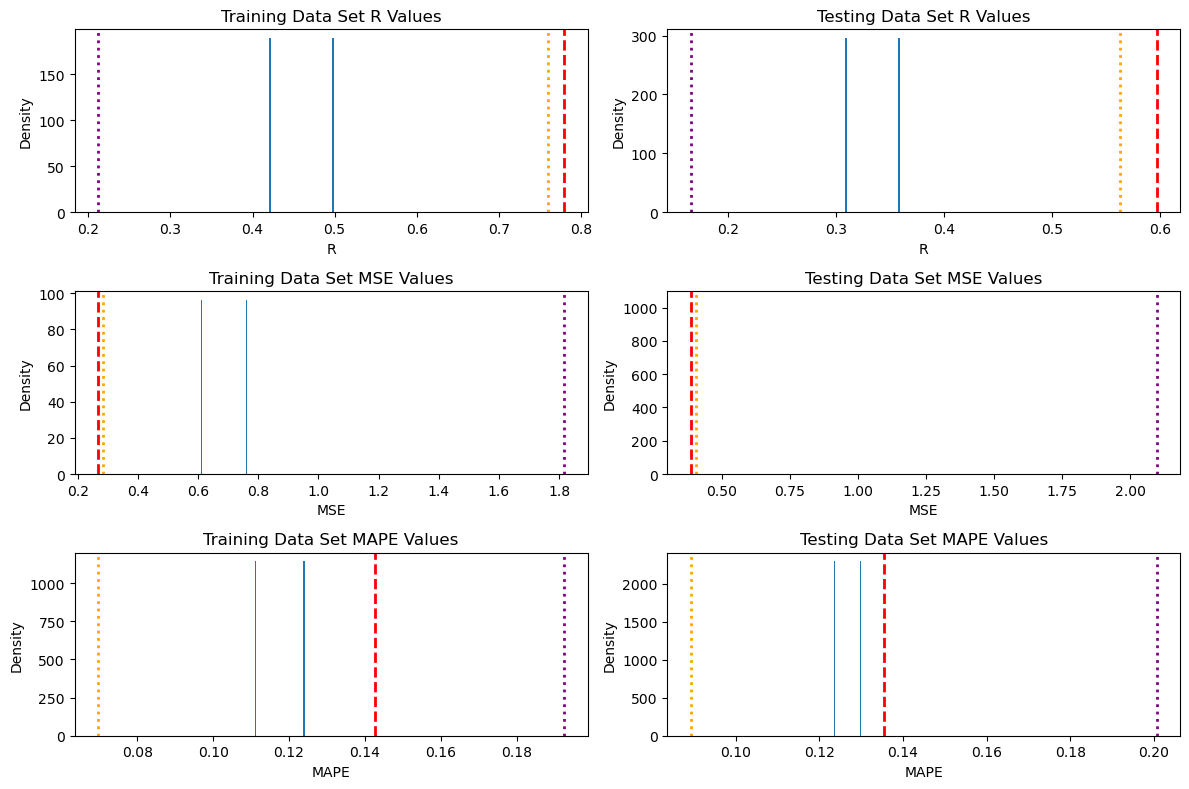

In [21]:
# Visualize the metrics in Gaussian curves along with reference values
plt.figure(figsize=(12, 8))

plt.subplot(3, 2, 1)
plt.hist(train_r_values, bins=30, density=True)
plt.axvline(reference_values["Training Data Set"]["R"], color='r', linestyle='dashed', linewidth=2)
plt.axvline(reference_values["Training Data Set SVR"]["R"], color='orange', linestyle='dotted', linewidth=2)
plt.axvline(reference_values["Training Data Set ANN"]["R"], color='purple', linestyle='dotted', linewidth=2)
plt.title('Training Data Set R Values')
plt.xlabel('R')
plt.ylabel('Density')

plt.subplot(3, 2, 2)
plt.hist(test_r_values, bins=30, density=True)
plt.axvline(reference_values["Testing Data Set"]["R"], color='r', linestyle='dashed', linewidth=2)
plt.axvline(reference_values["Testing Data Set SVR"]["R"], color='orange', linestyle='dotted', linewidth=2)
plt.axvline(reference_values["Testing Data Set ANN"]["R"], color='purple', linestyle='dotted', linewidth=2)
plt.title('Testing Data Set R Values')
plt.xlabel('R')
plt.ylabel('Density')

plt.subplot(3, 2, 3)
plt.hist(train_mse_values, bins=30, density=True)
plt.axvline(reference_values["Training Data Set"]["MSE"], color='r', linestyle='dashed', linewidth=2)
plt.axvline(reference_values["Training Data Set SVR"]["MSE"], color='orange', linestyle='dotted', linewidth=2)
plt.axvline(reference_values["Training Data Set ANN"]["MSE"], color='purple', linestyle='dotted', linewidth=2)
plt.title('Training Data Set MSE Values')
plt.xlabel('MSE')
plt.ylabel('Density')

plt.subplot(3, 2, 4)
plt.hist(test_mse_values, bins=30, density=True)
plt.axvline(reference_values["Testing Data Set"]["MSE"], color='r', linestyle='dashed', linewidth=2)
plt.axvline(reference_values["Testing Data Set SVR"]["MSE"], color='orange', linestyle='dotted', linewidth=2)
plt.axvline(reference_values["Testing Data Set ANN"]["MSE"], color='purple', linestyle='dotted', linewidth=2)
plt.title('Testing Data Set MSE Values')
plt.xlabel('MSE')
plt.ylabel('Density')

plt.subplot(3, 2, 5)
plt.hist(train_mape_values, bins=30, density=True)
plt.axvline(reference_values["Training Data Set"]["MAPE"], color='r', linestyle='dashed', linewidth=2)
plt.axvline(reference_values["Training Data Set SVR"]["MAPE"], color='orange', linestyle='dotted', linewidth=2)
plt.axvline(reference_values["Training Data Set ANN"]["MAPE"], color='purple', linestyle='dotted', linewidth=2)
plt.title('Training Data Set MAPE Values')
plt.xlabel('MAPE')
plt.ylabel('Density')

plt.subplot(3, 2, 6)
plt.hist(test_mape_values, bins=30, density=True)
plt.axvline(reference_values["Testing Data Set"]["MAPE"], color='r', linestyle='dashed', linewidth=2)
plt.axvline(reference_values["Testing Data Set SVR"]["MAPE"], color='orange', linestyle='dotted', linewidth=2)
plt.axvline(reference_values["Testing Data Set ANN"]["MAPE"], color='purple', linestyle='dotted', linewidth=2)
plt.title('Testing Data Set MAPE Values')
plt.xlabel('MAPE')
plt.ylabel('Density')

plt.tight_layout()
plt.show()
